# *Credit Card Fraud Predictive Model*

#### Manna Sirak

# Data Description

In an increasingly digitized world, identity theft is, unfortunately, not a particularly uncommon occurrence. 47% of Americans have fallen victim to identity theft since 2014, with an average loss of $7,700. Companies and individuals worldwide lost 27 billion to credit card fraud in 2018 alone, with nearly 40% of that loss having occured in the U.S. Company security breaches carry dangerous risks with billions of consumers' personal information being compromised, and settlements can cost companies billions of dollars. Card fraud has proven to be a formidable threat to both institutions and individuals, so models identifying and predicting fraud are of primary interest to companies. In this project I will be attempting to create a predictive model towards this end. 

## Data Overview:

The present dataset is the result of a collaboration between two sizable research organizations, the Worldline and Machine Learning Group, and the University of Brussels. The dataset itself consists of records of transactions from over 280,000 cardholders from various European countries, with a portion of those being fraudulent. All transactions were in Euros and were made over the course of 2 days. Original dataset here: https://www.kaggle.com/mlg-ulb/creditcardfraud

Most of the 31 variables are numerical inputs resulting from a PCA (Principal Component Analysis) transformation. PCA, a dimensionality reduction technique, is typically helpful when reducing the number of variables to those most relevant. As will be discussed later, this transformation makes it somewhat more difficult to draw actionable directives from the analysis and comparatively obscures the significance of our outcomes. However, the gatherers of the dataset felt it was a necessary step in protecting the confidentiality of the cardholders’ data. 

It can be inferred that prior to PCA transformation, those variables may have included transaction characteristics such as location or website on which the transaction was made; to reveal those variables may have been a violation of customer privacy laws. 

Three out of the 31 variables had not been transformed: the time of the transaction in seconds after the beginning of the 48 hour period, the transaction amount in Euros, and the transaction class (a binary variable indicating whether that particular transaction or observation was or was not fraudulent).

Import core libraries

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import numpy as np
import missingno as msng

Below, I read in the dataset as a dataframe.

In [5]:
path = r'creditcard.csv'
trans_df = pd.read_csv(path)
trans_df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Below I separate the transactions into fraudulent vs. non-fraudulent, and call the shape of the data as well as the number of fraudulent transactions. I subsequently call the describe function on the whole dataset in order to get an idea of the data's spread.

In [6]:
fraud_trans = trans_df[trans_df['Class'] == 1]
not_fraud_trans = trans_df[trans_df['Class'] == 0]
print("Shape of the Data: ", trans_df.shape)
print("Count of Fraud Transactions :", len(fraud_trans))
print("")
trans_df.describe()

Shape of the Data:  (284807, 31)
Count of Fraud Transactions : 492



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
trans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

## Preprocessing

### Null Value Analysis

As with any analyses, an accurate assessment of missing values is necessary. As outlined below, the current dataset had no missing values.

In [16]:
missing_d = np.where(trans_df.isna())

missing_data = np.shape(missing_d)[0] * np.shape(missing_d)[1]
all_data = np.shape(trans_df)[0] * np.shape(trans_df)[1]
print('Missing entries: {0} of {1} ({2:.0f}%)'.format(missing_data, all_data, missing_data/all_data*100))

Missing entries: 0 of 8829017 (0%)


### Resampling

When implementing a classification algorithm, data imbalances such as the one present with this dataset present a significant validity issue. This imbalance necessitates a process of data resampling such that the number of fraudulent and legitimate transactions utilized in the subsequent modeling steps is the same. This is outlined in the cell below and will become especially relevant in Modeling Approach 2 below.

In [20]:
def resample_data(X_train, y_train, fraud_percentage, total):   
    train = pd.concat([X_train, y_train], axis = 1)
    
    train_fraud = train[train['Class'] == 1]
    train_not_fraud = train[train['Class'] == 0]
    
    fraud_size = int(fraud_percentage * total)
    non_fraud_size = total - fraud_size
    #re-nsampling non-fraud and fraud transactions
    if len(train_not_fraud) != non_fraud_size:
        train_not_fraud = resample(train_not_fraud, replace = True, n_samples = non_fraud_size, random_state = 42).reset_index(drop = True)
    if len(train_fraud) != fraud_size:
        train_fraud = resample(train_fraud, replace = True, n_samples = fraud_size, random_state = 42).reset_index(drop = True)
    #merging the 2 classes back
    down_train = pd.concat([train_fraud, train_not_fraud], axis = 0)
    y_train = down_train['Class']
    X_train = down_train.drop('Class', axis = 1).reset_index(drop = True)
    return X_train, y_train

y = trans_df['Class']
X = trans_df.drop('Class', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Count before re-sampling   1:", list(y_train).count(1), ' 0:', list(y_train).count(0))
X_train, y_train = resample_data(X_train, y_train, 0.5, 788)
print("Count after re-sampling    1:", list(y_train).count(1), ' 0:', list(y_train).count(0))



Count before re-sampling   1: 394  0: 227451
Count after re-sampling    1: 394  0: 394


# Exploratory Data Analysis

Below, I include a few important histograms.

Text(0, 0.5, 'Count')

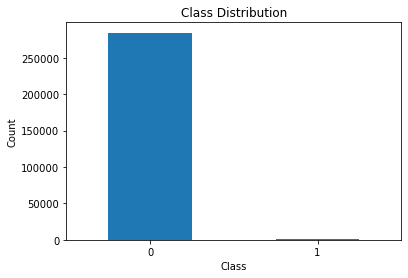

In [8]:
cl_hist = trans_df['Class'].value_counts().plot(kind='bar', rot=0, title='Class Distribution')
cl_hist.set_xlabel('Class')
cl_hist.set_ylabel('Count')

As one might expect with data of this nature, there is a vast imbalance in the dependent variable - generally, one would hope that a significant portion of any set of transactions was not fraudulent. Here, out of the 285,299 transactions, 492 were fraudulent, less than 0.2%. Though this presents somewhat of an inconvenience in terms of our modeling techniques, this is representative of what this data would look like in the real world – realistically, only a small portion of the transactions tracked by any given financial institutions will be fraudulent. This imbalance is taken into account when performing the analyses detailed later in the current manuscript. In terms of the modeling techniques implemented in the following sections, the classification nature of the analysis necessitates data resampling. 

In [9]:
grouped = trans_df.groupby('Class').mean()
cl_means = grouped[['Amount']]
cl_means

,Amount
Class,
0,88.291022
1,122.211321


As the table above indicates, the mean of fraudulent transactions is significantly higher than that of legitimate transactions.

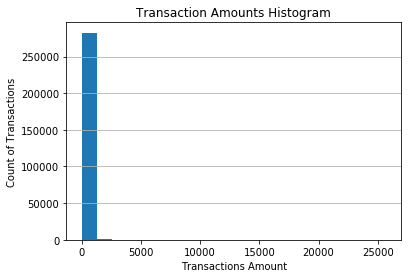

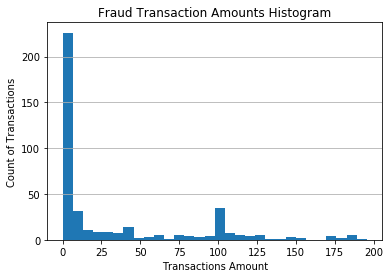

In [10]:
#Histogram with 100 bins
plt.title('Transaction Amounts Histogram')
plt.grid(which = 'major', axis='y')
plt.ylabel('Count of Transactions' )
plt.xlabel('Transactions Amount')
plt.hist(not_fraud_trans['Amount'], bins = 20)
plt.show()
#Fraud Transaction Amount Histogram
fraud_trans = fraud_trans[fraud_trans['Amount']<200]
plt.title('Fraud Transaction Amounts Histogram')
plt.grid(which = 'major', axis='y')
plt.ylabel('Count of Transactions' )
plt.xlabel('Transactions Amount')
plt.hist(fraud_trans['Amount'], bins = 30)
plt.show()

Above are distributions for fraudulent and non-fraudulent transactions by their respective amount. The non-fraud transactions’ amounts range between 0-25000, whereas the distribution for the fraud transactions show a range from 0–2000. Similarly to time of transaction, we can say that amount may play a significant role in the fraud predictions.

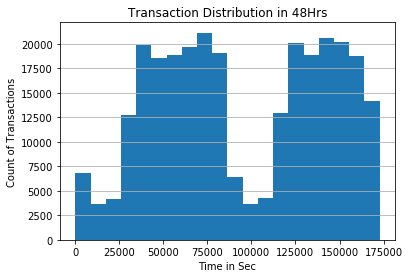

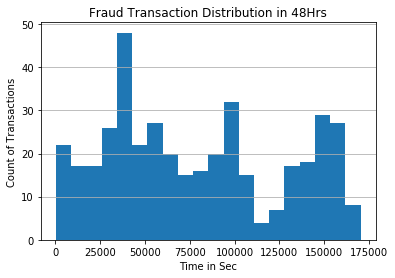

In [11]:
#Histogram with 100 bins
plt.title('Transaction Distribution in 48Hrs')
plt.grid(which = 'major', axis='y')
plt.ylabel('Count of Transactions' )
plt.xlabel('Time in Sec')
plt.hist(trans_df['Time'], bins = 20)
plt.show()
#Fraud Transaction Amount Histogram
plt.title('Fraud Transaction Distribution in 48Hrs')
plt.grid(which = 'major', axis='y')
plt.ylabel('Count of Transactions' )
plt.xlabel('Time in Sec')
plt.hist(fraud_trans['Time'], bins = 20)
plt.show()

The plot for the Non-Fraud transactions above has a cyclic pattern which is in reference to the normal behavioral pattern of transactions in a day. The other plot, however, is for fraudulent transactions and has no pattern. This implies that time is an important feature in modeling fraud predictions.

Below are the boxplots for transaction amount of legitimate and fraudulent. Both datasets seem to have a number of outliers.

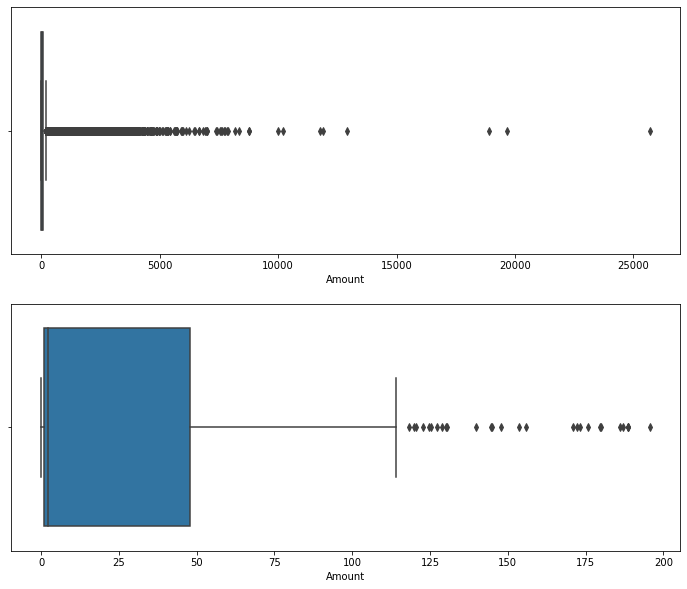

In [12]:
# Transaction Amount Distribution 
fig, axs = plt.subplots(2,figsize=(12,10))
sns.boxplot(x = trans_df['Amount'], ax=axs[0])
sns.boxplot(x = fraud_trans['Amount'], ax=axs[1])

Even without information as to what PCA variables mean, it is useful to visualize the spread of each type of 'Class' over each of these features. Histograms depicting this for all variables are below.

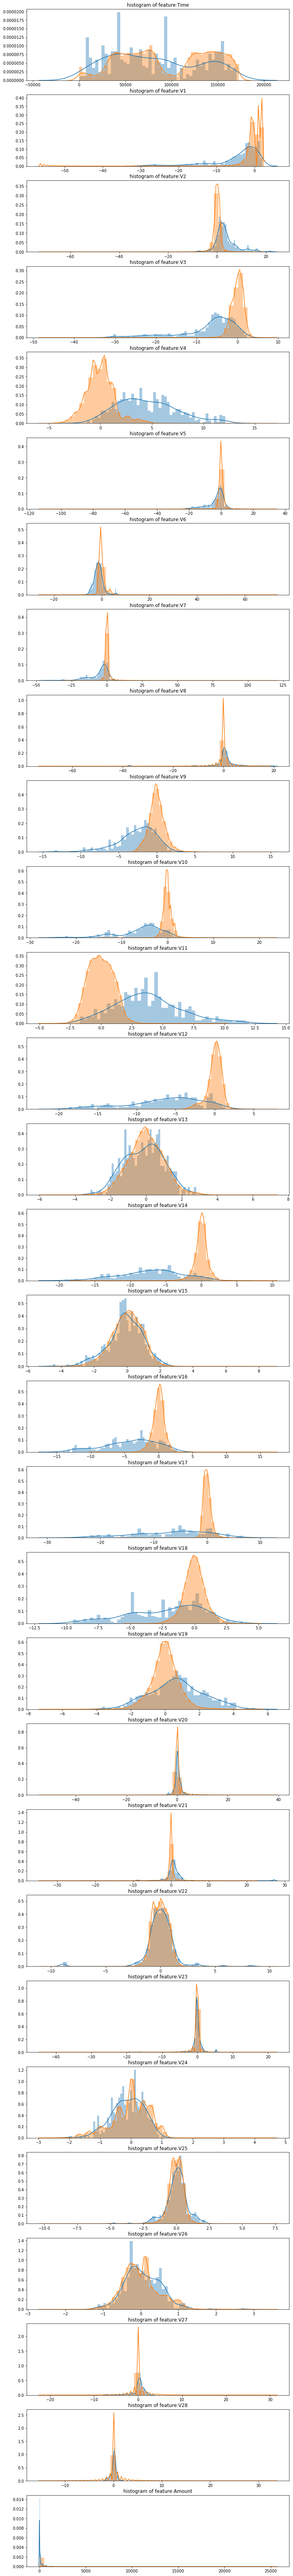

In [21]:
from matplotlib import gridspec
features = trans_df.iloc[:,0:30].columns
plt.figure(figsize=(12,31*4))
gs = gridspec.GridSpec(31, 1)
for i, c in enumerate(trans_df[features]):
 ax = plt.subplot(gs[i])
 sns.distplot(trans_df[c][trans_df.Class == 1], bins=50)
 sns.distplot(trans_df[c][trans_df.Class == 0], bins=50)
 ax.set_xlabel('')
 ax.set_title('histogram of feature:' + str(c))
plt.show()

As can be seen from the above plots, the features that have significant overlap for both the classes are V13, V15, V22, V24, V25 and V26. These are some of the features that may be useful in modeling the accurate predictions.

# Feature Engineering


Here, I define my target and predictor variables for convenience with implementation later.

In [22]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

# Modeling Approach 1

For the first modelling approach, I created the model on unbalanced data and considered all features included in the dataset. Given the class imbalance ratio, I recommend measuring the accuracy using the Area Under the Curve (AUC). Confusion matrix accuracy is not meaningful for unbalanced classification, though both are showcased both below for observational purposes. Below I split the data into reproducible validation and test sets and subsequently applied three modeling techniques: 
1.	Random Forest Classifier: Random Forests or Random Decision Forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.
2.	Adaptive Boosting Classifier: AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers.
3.	XG Boost: Extreme Gradient Boosting is also known as XG Boost. This model is preferred due to its execution speed and learning performance.


## Random Forest

In [23]:
VALID_SIZE = 0.20 # simple validation using train_test_split
RANDOM_STATE = 2018
train_df, valid_df = train_test_split(trans_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [24]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
                       oob_score=False, random_state=2018, verbose=False,
                       warm_start=False)

Random Forest is, summarily, a collection of decision tree classifiers implemented for classification and regression. Random forest has advantage over decision tree as it corrects the habit of over fitting to their training set. In its implementation, a subset of the training set is sampled randomly in order to train each individual tree, and then a decision tree is built. Each node then splits on a feature selected from a random subset of the full feature set. Even for large data sets with many features, training is extremely fast because each tree is trained independently of the others. The Random Forest algorithm has been found to provide a good estimate of the generalization error and to be resistant to over fitting.

An advantage of using this technique here is that Random Forest ranks the importance of variables in a regression or classification problem in a natural way. A primary disadvantage here is that the Random forest algorithm will perform better with a larger number of training data, but speed during testing and application will suffer. Below is a visual representation of the imporance of the features, ranked. 

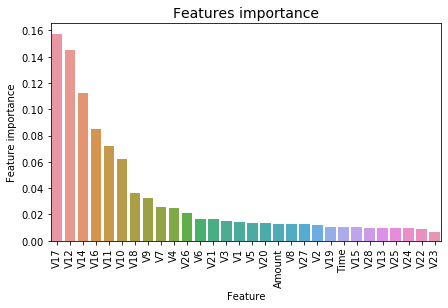

In [25]:
preds = clf.predict(valid_df[predictors])
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

With Random Forest classifier, we saw the following:
- Most important features:
      V17, V12, V14, V16, V11
- Least important features:
      V25, V24, V23


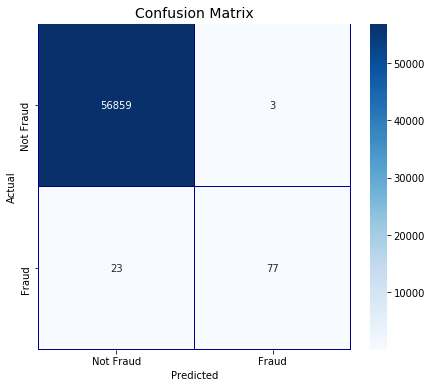

AUC-ROC Curve:  0.8849736203439907


In [31]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(7,6))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt = 'd')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

auc = roc_auc_score(valid_df[target].values, preds)
print('AUC-ROC Curve: ', auc)

Though it is included above, a confusion matrix is not the most effective representation of classification results in the event of large dataset imbalances. Here, since the sample size of legitimate transactions far outweighs fraudulent ones, the model is able to predict well values for the class with an abundance of data points, while inadvertently treating features of the minority class as noise. There is a high probability that minority class values will be inaccurately classified here.

A much more appropriate measure of model performance is a AUC-ROC score. AUC is an abbrevation for area under the curve and is used in classification analysis in order to determine which of the models in question is most accurately predictive. An example of its application is the ROC curve, in which the true positive rates are plotted against false positive rates. The Random Forest classification algorithm above produces a AUC-ROC score of 0.8849, indicating a moderately good fit to the dataset.

## AdaBoostClassifier AKA Adaptive Boosting Classifier 

Adaptive Boosting or AdaBoost is used in conjunction with different types of machine learning algorithms to improve their performance. The common algorithms AdaBoost uses are decision trees with level one. AdaBoost is especially useful when working with weak learners, classifiers or predictors which perform relatively poorly in terms of accuracy.

Apart from being speedy and easy to program, an advantage of using AdaBoost is its flexibility in being combined with any machine learning algorithm, which can remove the need to tune the parameters. AdaBoost also has few disadvantages, one being that it can be particularly vulnerable to uniform noise - weak classifiers being too weak can lead to low margins and overfitting.

In [33]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)
clf.fit(train_df[predictors], train_df[target].values)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.8,
                   n_estimators=100, random_state=2018)

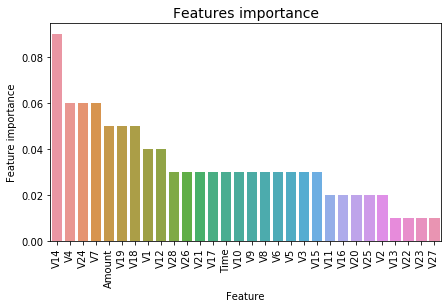

In [34]:
preds = clf.predict(valid_df[predictors])
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

After using the Adaptive Boosting classifier, we saw the following:
- Most important features:
      V14, V4, V24, V7, V19
- Least important features:
      V22, V23, V27


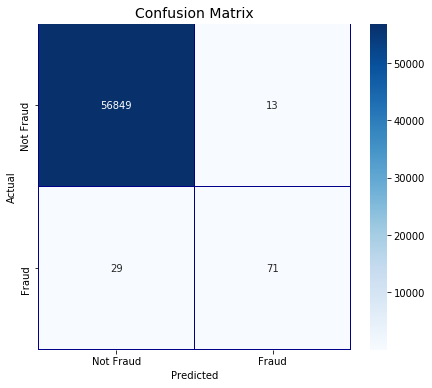

AUC-ROC Curve:  0.8548856881572932


In [35]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(7,6))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues", fmt = 'd')
plt.title('Confusion Matrix', fontsize=14)
plt.show()

auc = roc_auc_score(valid_df[target].values, preds)
print('AUC-ROC Curve: ', auc)

Again, the confusion matrix was included above though it is less accurate than AUC-ROC as a measure of model performance. The AdaBoost algorithm produced an AUC-ROC score of 0.8548, indicating a slightly less optimal fit than the Random Forest classifier used previously.

## XGBoost Classifier

XGBoost is a decision-tree-based ensemble machine learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks.

Among several other benefits, XG boost has been preferred over other models because of the following main reasons: regularization, which prevents the model from overfitting, and is the reason XGBoost is sometimes referred to as a regularized form of GBM (Gradient Boosting Machine); its ability to utilize parallel processing, allowing it to run much faster than other models; implicit cross validation, which allows users to run a cross-validation at each iteration of the boosting process, making it is easy to get the exact optimum number of boosting iterations in a single run; and effective tree pruning, which splits up to the max_depth specified and subsequently starts pruning the tree backwards and removing splits beyond which there is no positive gain.

In [27]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(valid_df[predictors], valid_df[target].values)

# What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [28]:
MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 85 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 85 #Print out metric result
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[16:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-auc:0.88379	valid-auc:0.86983
[2]	train-auc:0.88379	valid-auc:0.86983
[3]	train-auc:0.88379	valid-auc:0.86983
[4]	train-auc:0.88379	valid-auc:0.86983
[5]	train-auc:0.88762	valid-auc:0.87484
[6]	train-auc:0.88762	valid-auc:0.87484
[7]	train-auc:0.88762	valid-auc:0.87484
[8]	train-auc:0.88762	valid-auc:0.87484
[9]	train-auc:0.88764	valid-auc:0.87483
[10]	train-auc:0.88766	valid-auc:0.87486
[11]	train-auc:0.88766	valid-auc:0.87486
[12]	train-auc:0.89773	valid-auc:0.88971
[13]	train-auc:0.89774	valid-auc:0.88971
[14]	train-auc:0.90537	valid-auc:0.90470
[15]	train-auc:0.92065	valid-auc:0.91466
[16]	train

[192]	train-auc:0.98782	valid-auc:0.96609
[193]	train-auc:0.98791	valid-auc:0.96628
[194]	train-auc:0.98787	valid-auc:0.96638
[195]	train-auc:0.98782	valid-auc:0.96627
[196]	train-auc:0.98788	valid-auc:0.96670
[197]	train-auc:0.98805	valid-auc:0.96528
[198]	train-auc:0.98839	valid-auc:0.96665
[199]	train-auc:0.98836	valid-auc:0.96763
[200]	train-auc:0.98866	valid-auc:0.96784
[201]	train-auc:0.98885	valid-auc:0.96776
[202]	train-auc:0.98898	valid-auc:0.96777
[203]	train-auc:0.98911	valid-auc:0.96752
[204]	train-auc:0.98922	valid-auc:0.96879
[205]	train-auc:0.98934	valid-auc:0.96925
[206]	train-auc:0.98951	valid-auc:0.96913
[207]	train-auc:0.98947	valid-auc:0.96918
[208]	train-auc:0.98946	valid-auc:0.96919
[209]	train-auc:0.98956	valid-auc:0.96974
[210]	train-auc:0.98947	valid-auc:0.96976
[211]	train-auc:0.98960	valid-auc:0.96979
[212]	train-auc:0.98963	valid-auc:0.96964
[213]	train-auc:0.98971	valid-auc:0.97020
[214]	train-auc:0.98964	valid-auc:0.97032
[215]	train-auc:0.98970	valid-auc:

[390]	train-auc:0.99618	valid-auc:0.97644
[391]	train-auc:0.99621	valid-auc:0.97653
[392]	train-auc:0.99623	valid-auc:0.97632
[393]	train-auc:0.99625	valid-auc:0.97614
[394]	train-auc:0.99628	valid-auc:0.97607
[395]	train-auc:0.99628	valid-auc:0.97604
[396]	train-auc:0.99630	valid-auc:0.97624
[397]	train-auc:0.99631	valid-auc:0.97657
[398]	train-auc:0.99635	valid-auc:0.97651
[399]	train-auc:0.99640	valid-auc:0.97651
[400]	train-auc:0.99641	valid-auc:0.97639
[401]	train-auc:0.99641	valid-auc:0.97630
[402]	train-auc:0.99641	valid-auc:0.97650
[403]	train-auc:0.99641	valid-auc:0.97652
[404]	train-auc:0.99644	valid-auc:0.97641
[405]	train-auc:0.99647	valid-auc:0.97644
[406]	train-auc:0.99649	valid-auc:0.97653
[407]	train-auc:0.99648	valid-auc:0.97657
[408]	train-auc:0.99652	valid-auc:0.97666
[409]	train-auc:0.99654	valid-auc:0.97660
[410]	train-auc:0.99655	valid-auc:0.97665
[411]	train-auc:0.99657	valid-auc:0.97657
[412]	train-auc:0.99657	valid-auc:0.97705
[413]	train-auc:0.99658	valid-auc:

[588]	train-auc:0.99833	valid-auc:0.97779
[589]	train-auc:0.99835	valid-auc:0.97796
[590]	train-auc:0.99835	valid-auc:0.97797
[591]	train-auc:0.99835	valid-auc:0.97785
[592]	train-auc:0.99837	valid-auc:0.97764
[593]	train-auc:0.99838	valid-auc:0.97751
[594]	train-auc:0.99838	valid-auc:0.97760
[596]	train-auc:0.99841	valid-auc:0.97767
[597]	train-auc:0.99841	valid-auc:0.97776
[598]	train-auc:0.99842	valid-auc:0.97782
[599]	train-auc:0.99843	valid-auc:0.97775
[600]	train-auc:0.99842	valid-auc:0.97773
[601]	train-auc:0.99843	valid-auc:0.97794
[602]	train-auc:0.99843	valid-auc:0.97798
[603]	train-auc:0.99846	valid-auc:0.97768
[604]	train-auc:0.99846	valid-auc:0.97750
[605]	train-auc:0.99847	valid-auc:0.97762
[606]	train-auc:0.99848	valid-auc:0.97756
[607]	train-auc:0.99848	valid-auc:0.97766
[608]	train-auc:0.99850	valid-auc:0.97755
[609]	train-auc:0.99850	valid-auc:0.97750
[610]	train-auc:0.99851	valid-auc:0.97740
[611]	train-auc:0.99851	valid-auc:0.97739
[612]	train-auc:0.99851	valid-auc:

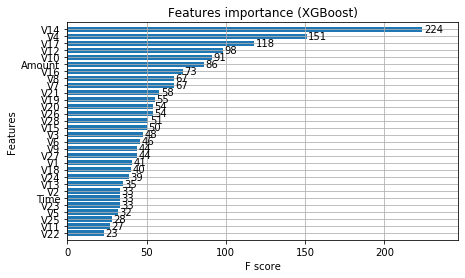

In [29]:
fig, (ax) = plt.subplots(ncols=1, figsize=(7,4))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax) 
plt.show()


In [32]:
preds = model.predict(dtest)
auc1 = roc_auc_score(valid_df[target].values, preds)
print('AUC-ROC Curve: ', auc1)

AUC-ROC Curve:  0.9769494565790862


Optimal results under the XGBoost algorithm were obtained at the 620th iteration, producing an AUC score of 0.9769.

Although the above results obtained by XG boost may be considered near ideal, the above approach is not recommended due to the unbalanced nature of this dataset. The above approach is to present the difference between the results if the data is unbalanced and if all features are included. 

In the following section, I take a much more focused approach, in which models are applied after having both resampled the dataset in order to balance it and having removed irrelevant features.

# Modeling Approach 2



In this section, I utilized balanced train and test samples produced in the preprocessing section towards the beginning of this analysis. Initially, the numbers were as follows: for the training subsample, which was 80% of the overall sample, the number of fraudulent observations was 394, while non-fraudulent was 227,451. For test data, 20% of the sample, the number of fraudulent observations was 98, while non-fraudulent was 5,686. 

While preprocessing, I used sampling techniques to balance the data and bring the ratio of the classes to 1:1. Different balancing ratios were attempted, but 1:1 for both classes worked best. After applying these steps to the training subsample, I ended up with 394 fraudulent and 394 non-fraudulent transactions.

## Random Forest

In the Modeling Approach 1 section above, I tried out various algorithms for training the data and observed that the Random Forest classifier gave the best performance. Although Random Forest and XGBoost performed similarly on the unbalanced dataset as showcased above, Random Forest displayed a better trade-off between the true and false positive rates as compared to XGBoost. Upon further analysis as outlined below, this is shown to also be the case for the balanced dataset. Compared to XGBoost, the predicted probabilities of the Random Forest classifier served better for the purpose of tuning the cutoff probability for better trade-off between the true-positive and false-positive rate.

In [54]:
RF_model = RandomForestClassifier(random_state=42, n_estimators = 100)
RF_model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Sensitivity(%)[1]: 93.87755102040816
Specificity(%)[0]: 97.61008722566122


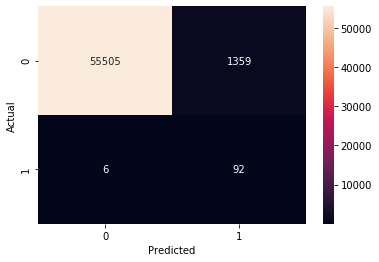

In [55]:
pred = RF_model.predict(X_test)
report = classification_report(y_test, pred, output_dict = True)
conf = confusion_matrix(y_test, pred)
ax = sns.heatmap(conf , annot=True, fmt = 'd')
ax.set(xlabel = 'Predicted', ylabel = 'Actual')
specificity = (conf[0][0]/(conf[0][0] + conf[0][1])) * 100
sensitivity = (conf[1][1]/(conf[1][0] + conf[1][1])) * 100

print("Sensitivity(%)[1]:", sensitivity)
print("Specificity(%)[0]:",specificity)


As displayed in the confusion matrix above, the Random Forest algorithm produced a true-positive rate of 93.9% and a true-negative rate of 97.5%. Though specificity is very high and only 2.5% of the negative samples are mislabeled as positive, the number of samples is still high (1,423). The objective of the model is to not only increase the true positives but also avoid too many the false positives.

To decrease the false positives, I came up with a new solution by only labeling the samples as positives (fraudulent) if the probability was high (greater than the default 50%). We generated results for different probabilities and P = 0.55 demonstrated the best trade-off between true-positives and false-positives. After using the new P = 0.55 probability for classifying the transactions, the proportions produced were as follows:

Sensitivity(%)[1]: 93.87755102040816
Specificity(%)[0]: 98.7426139561058


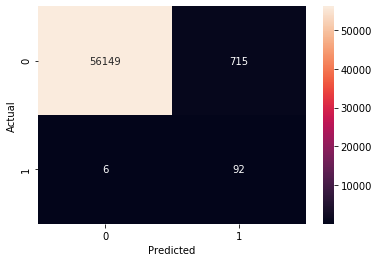

In [9]:
prob = RF_model.predict_proba(X_test)
pred = (prob[:,1] >= 0.55).astype(bool)
report = classification_report(y_test, pred, output_dict = True)
conf = confusion_matrix(y_test, pred)
ax = sns.heatmap(conf , annot=True, fmt = 'd')
ax.set(xlabel = 'Predicted', ylabel = 'Actual')
specificity = (conf[0][0]/(conf[0][0] + conf[0][1])) * 100
sensitivity = (conf[1][1]/(conf[1][0] + conf[1][1])) * 100

print("Sensitivity(%)[1]:", sensitivity)
print("Specificity(%)[0]:",specificity)



As we can see from the above confusion matrix, classifying transactions as fraudulent only in the case that their probability is above 0.55 decreased the number of false positives by 50.25%, from 1,423 to 715. Finally, this optimal set of techniques produced an ROC-AUC score of 0.9631 as depicted in the AUC graph below.

Area under Curve ROC:  0.9631008248825699


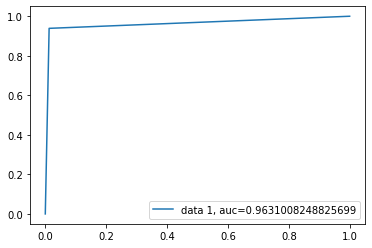

In [10]:
fpr, tpr, _ = roc_curve(y_test,pred)
auc = roc_auc_score(y_test, pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
print('Area under Curve ROC: ', auc)
plt.show()

# Business Insights and Conclusion

It is important to analyze the data and the performance of the model in terms of how well the business problem is addressed. In addition, it is important to get a quantitative estimate of how much a financial institution stands to benefit by making use of this model in their real-time transactions.

Considering the test data, we observe here how much difference each model makes. Overall, our test data consisted of 98 fraud transactions and 5,686 non-fraud transactions. So, in the current scenario of not using any system to detect fraud, the following is the standing of any given financial institution:

Average Transaction Amount in Fraud Transaction - 88.4 €
Average Cost of Fraud Transaction Investigation - 7 €  

**Current Loss: 98 * 88.4 = 8663 €**

After using the down-sampling technique detailed in the Modeling Approach 2 section above to balance the dataset, we can make the following conclusions:
False Negatives:  6 * 88.4 = 530.4 € 
False Positives:  1,423 * 7 = 9,961 €  
530.4 + 9,961 = 10,491 €     

**Loss after Modeling Approach 2 = 10,491 € (8,663 – 10,491 = -1828.4 €)
We see that loss increased by 1828.4 €, which is not an ideal outcome.**

If the model is run after using the recommended approach of balancing and tuning the cutoff probability at P = 0.55 instead of simply balancing, we can make the following conclusions:
False Negatives:  6 * 88.4 = 530.4 €    
False Positives:  715 * 7 = 5005 €  
530.4 + 5005 = 5535.4 €

**Loss after tuned (P=0.55) Modeling Approach 2 = 5535.4 € (8663 – 5535.4 = 3127 €)
We see that loss decreased by 3127 €, and can safely state that this is a significantly more beneficial modeling approach.**

Credit card fraud is one of the foremost ways by which companies and individuals stand to lose money. As anyone is a potential victim, producing the most accurate models by which to analyze and predict fraud risk is of utmost importance. The current analysis provided a detailed overview of one such model, taking into consideration the various challenges present with this specific dataset. This analysis attempted to fit the dataset with various models, finally settling on the Random Forest classifier after having corrected for the dataset’s significant imbalance in terms of the variable of interest, and further specifying an ideal cutoff probability in order to reduce the number of false positives. Finally, I outlined here applications for this analysis in a business setting, demonstrating the effectiveness of our model in reducing the real-time costs of preventing fraud. Overall, this extensive analyses showcase the various factors that should be taken into consideration when working with sensitive consumer data, and display the various reasons analyses of this nature present real business value to anyone attempting to protect themselves from card fraud.